A bow shock has been detected near Cyg X-1. It appears that the jets from CygX-1 have plunged into the higher density ISM and created a bow shock, a semi-circular region seen on only one side of CygX-1. The jets from the black hole X-ray binary create a shock front, which creates an overpressured lobe. The continous pumping of gas into this lobe results in the sideways expansion of the lobe. In order to determine the energy transported to the ISM, the first step is to find out the density of the ISM near Cyg X-1. So the steps are as follows-
1) Find the electron density and temperature of the gas based on the comparison of radio vs Halpha surface brightness

    a) This would have been the most ideal case, but because the Halpha maps are contaminated heavily by the foreground stars, the Halpha flux and emitting area estimations are not solid.
    
    b) Instead, I will plot the curve of the relation between temperature and electron density, based off of the measured flux and volume of the bow shock from the MeerKAT image.

2) I will then use the temperature and electron density ranges to estimate the velocity of the bow shock. I might use the MC simulations here to ensure that the priors on the temperature and electron density are taken care off.

3) Using the velocity and the characteristic length of the jet, we can find the age of the jets (Again MC simulations here to get a distribution of the age of the jets).

4) The age will lead to the energy transport rate.

In [7]:
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
#import aplpy

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special

from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import gaussian_kde,rv_continuous
from scipy.interpolate import interp1d

import os
from astropy import units as u
from astropy.units import cds
from matplotlib import colors
cds.enable()  

In [2]:
#New measured quantities in this work
F_total = 0.037 #Integrated Bow shock flux in Jy
F = 0.00014         #Mean Bow shock flux density in Jy/beam 
F_err = 0.000035
DRmin = 1.5           #Ring thickness, arcmin 
DRmin_err = 0.3
theam = 8.8      #Lobe diameter in arcmin (noted between the inner edges of the lobe)
disamin = 10.8 #angular seperation between Cyg X-1 and the leading edge of the bowshock in arcmin
disamin_err = 0.2
proj_shock = 84000 #projected area of the bowshock in arcsec2 (used ds9 for this)
#Literature Source specific quantities 
d = 2.2            #distance to Cyg X-1 in kpc, Miller-Jones et al. 2021
d_err = 0.18        #error in distance measured 
incl = 27.51        #inclination angle, Miller-Jones et al. 2021
incl_err = 0.18     #error inclination angle, Miller-Jones et al. 2021
o_a = 30             #opening angle
o_a_err = 0         #opening angle error

In [16]:
#Constants

pc = 3.086E+18       # 1 pc, cm 
mh = 1.6735575E-24   # Hydrogen mass, g 
me = 9.1093837E-28   # Electron mass, g 
eV = 1.602176634E-12 # ElectronVolt, erg
Jy = 1.0E-23         # 1 Jansky (erg/s/cm2/Hz), cgs
kb = 1.380649E-16;   # K boltzman, cgs
h =  6.6261E-27;     # Plank constant, cgs 
c = 3.0e10           # Speed of light, cgs 
Na = 6.022E+23       # Avogadro's number
Z=1                  # Hydrogen atomic number
e = 4.8e-10          #electric charge cm3/2 g1/2 s-1
x=1                  #ionisation fraction
C_radio = 6.8*1e-38
Gammac = 5/3                            # Adiabatic index of the material in the cavity, -- ASSUMED 
Gammax = 5/3                            # Adiabatic index of the material in the external medium, -- ASSUMED 
Gammaj = 5/3                            # Adiabatic index of the material in the jet, -- ASSUMED 
beta = 0                                # density profile index (beta = 0 for a uniform density medium), -- ASSUMED 

# Observation-specific quantities
nu = 1.2839E+9;         # Observing frequency (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj = 6.6            # Beam major axis, arcsec
bmin = 6.6            # Beam minor axis, arcsec

#Conversion of the newly measured source specific quantities

#various aspects of the ring thickness
DR = DRmin*60      #Ring thickness, arcsec
DRpc = d*1e3*4.8*1e-6*DR #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm = DRpc*pc    #Ring thickness in cm 

DR_err = DRmin_err*60
DRpc_err = d*1e3*4.8*1e-6*DR_err #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_err = DRpc_err*pc    #Ring thickness in cm 


#various aspects of the area of of the bowshock
proj_shock_pc = proj_shock*(d*1e3*4.8*1e-6)**2 #convert area from arcsec to pc
proj_volume_pc = DRpc*proj_shock_pc #convert the pc area to pc volume
proj_vol_cm = proj_volume_pc*((pc)**3) #convert the pc volume to cm3 volume

#Various aspects of the lobe diameter
lobesize_as = theam*60 #lobe diameter in arcseconds
lobesizepc = lobesize_as*d*1e3*4.8*1e-6    #lobe diameter in pc
lobesizecm = lobesizepc*pc      #lobe diameter in cm

#Various aspects of the angular seperation between the target and the leading edge of the bowshock
disasec = disamin*60 #lobe target seperation in arcsec (projected)
dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
discmP = dispc*pc #lobe target sepeartion in cm (projected)
discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle

#Printing the estimated values
print('Bow shock thickness in cm -','%.3e'%DRcm)
print('Diameter of the bowshock in cm -', '%.3e'%lobesizecm)
print('Seperation between Cyg X-1 and the bowshock in cm (de-projected) -', '%.3e'%discm) #Lj
print('Bow shock thickness in pc -','%.3f'%DRpc)
print('Diameter of the bowshock in pc -', '%.3f'%lobesizepc)
print('Seperation between Cyg X-1 and the bowshock in pc (projected) -', '%.3f'%dispc) #Lj
print('Bow shock Volume in pc3 -','%.3e'%DRpc)

Bow shock thickness in cm - 2.933e+18
Diameter of the bowshock in cm - 1.721e+19
Seperation between Cyg X-1 and the bowshock in cm (de-projected) - 4.572e+19
Bow shock thickness in pc - 0.950
Diameter of the bowshock in pc - 5.576
Seperation between Cyg X-1 and the bowshock in pc (projected) - 6.843
Bow shock Volume in pc3 - 9.504e-01


### Finding the electron density and temperature

The radio emissivity as given by (Longair 2011): The **monochromatic emissivity $\epsilon_\nu$ of ionised hydrogen due to thermal bremsstrahlung** is given by (Longair 1994). 

 $$\epsilon_\nu = \frac{L_\nu}{V} = 6.8\times 10^{-38} g(\nu, T) \frac{n_e^2}{\sqrt{T}} \exp{(\frac{h\nu}{k_b T})} ~~ erg~s^{-1}~cm^{-3}~Hz^{-1}$$

where $V$ is the volume of the emitting region. The way we estimate this is to find the area of the selected region in arcsec2 and multiply it by the thickness of the ring, assuming it to be as deep as it is wide. 

$$ L_\nu = F_\nu \times 4pi\times d^2 $$, which is the monochromatic luminosity. In the case of MeerKAT, we use monochromatic flux density ($F_\nu$) to present the flux density of a flat spectrum source at the central frequency of the observing band, and under the solid assumption that the flux does not change within the MeerKAT bandwidth. Another thing to note is that this is the integrate flux of the bowshock, as we are using the total volume of the emitting region to find the emissivity.

From the Bremsstrahlung emissivity we can derive the electron density, and from there the total number of particles based on the expected ionisation fraction $x \sim 1$ of a hydrogen gas emitting at a minimum temperature of T ~ 10$^4$K. At these temperatures almost all hydrogen will be ionised, so the ionisation fraction is 1.

$$n_e = \sqrt\frac{\epsilon_\nu}{g(\nu, T) \sqrt{T} C_{radio}}$$

where,

$$ C_{radio} = 6.8\times 10^{-38} erg~s^{-1}~cm^{-3}~Hz^{-1} $$,


$$
g(\nu, T) \approx \frac{\sqrt{3}}{2 \pi}\left[\ln \left(\frac{128 \epsilon_0^2 k^3 T^3}{m_e e^4 \nu^2 Z^2}\right)-\gamma^2\right]$$,


### To calculate the electron density using MC

In [5]:
def gaunt(nu, T, z):
    # The Gaunt factor  
    F1 = 128.*(1**2)*(kb**3)*(T**3)
    F2 = me * (e**4)*(nu**2)*(z**2)
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - 0.5772156649**2)
    return G

In [9]:
%matplotlib notebook
n_iter = 5000
n_cores = 16         # Number of parallel threads

In [10]:
class custom_dist_analytical(rv_continuous):
    def _pdf(self, xx):
        return testf(xx)

np.random.seed(124)

In [11]:
def ne(d,F,DR,T_axis,nu,Z):
    L14 = F*Jy*4*math.pi*(d*1e3*pc)**2 # Monochormatic ring luminosity in erg/sec/Hz
    #Vol = (DR*proj_shock*(d*1e3*4.8*1e-6*pc)**3)/(math.sin(incl*math.pi/180))
    Vol = (DR*proj_shock*(d*1e3*4.8*1e-6*pc)**3)
    #Vol = ((math.pi)*(bmaj/2)*(bmin/2))*(DR)*(d*1e3*4.8*1e-6*pc)**3 #Unit volume of the bowshock in cm3
    kappa_nu = L14 / Vol
    ne_squared = kappa_nu/(C_radio*(T_axis**-0.5) * gaunt(nu, T_axis, Z))
    n_e = (ne_squared**0.5) # units: cm^-3
    return n_e


In [12]:
# Source parameters:
dist = np.random.normal(d,d_err, n_iter)
Flux = np.random.normal(F_total,F_err,n_iter)
Ring_thic = np.random.normal(DR,DR_err,n_iter) #ring thickness in arcsec
T_axis = np.linspace(10**4,3*(10**6), n_iter, endpoint=True)

In [13]:
elec_density = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Flux[i],Ring_thic[i],T_axis[i],nu,Z) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 458 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    2.2s finished


In [ ]:
ne_T = ne(d,F_total,DR,T_axis,nu,Z) #only with temperature variation

In [ ]:
#To plot the variation of ne with T_axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Temperature [K]', fontsize=10)
ax.set_ylabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=10)
plt.tight_layout()

plt.scatter(T_axis,elec_density,s=11)

34.7148653950484 21.13821602606364 45.519177876466294


<IPython.core.display.Javascript object>


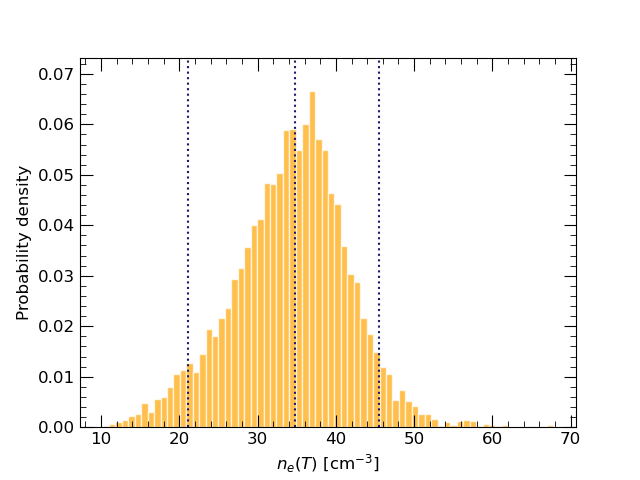

In [14]:
median = np.nanpercentile(elec_density,50)
low_lim = np.nanpercentile(elec_density,5)
high_lim = np.nanpercentile(elec_density,95)
print(median,low_lim,high_lim)
histplot = plt.hist(elec_density,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

## Calculating electron density with H alpha observations

We can find a similar relation by considering the H$\alpha$ surface brightness. For this, we can use the equation in Gvaramadze et al. (2018):

$$j_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2} \left( \frac{T}{\text{K}} \right)^{-0.9}\left(\frac{n_e}{\text{cm}^{-3}}\right)^2$$

The temperature and $n_e$ depend on position, but in our analysis, we have assumed they are uniform with depth. So then, we find that the surface brightness is given by:

$$S_{\rm H\alpha} = \int j_{\rm H\alpha}(x) dx = j_{\rm H\alpha} \Delta$$

Thus:

$$n_e(T) = \sqrt{S_{\rm H\alpha}\frac{(T/\text{K})^{0.9}}{C_{\rm H\alpha}\Delta}} \text{ cm}^{-3}$$ 

where $C_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2}$ and $\Delta$ is the width of the bowshock in cm.



In [32]:
Sh = 3.6e-15 * u.erg * ((u.second)**-1)*((u.cm)**-2)*((u.arcsecond)**-2) #obtained from Russell et al 2007 Table 2 and has the units ergs s-1 cm-2 arcsec-2
Sh_err = 1.8e-17 #assuming a 10% error margin on Sh
Ch = 2.85e-33* u.erg * ((u.second)**-1)*((u.cm)**-3)*((u.arcsecond)**-2) #Units of erg s-1 cm-3 arcsec-2

# Source parameters, :
Halpha_Flux = np.random.normal(Sh.value,Sh_err,n_iter)
Ring_thic_cm = np.random.normal(DRcm,DRcm_err,n_iter)

def ha_ne(S,T,Ring):
    Ha_ne = ((S*(T**0.9))/(Ch.value*Ring))**0.5
    return(Ha_ne)

In [33]:
elec_density_Ha = Parallel(n_jobs=n_cores,verbose=5)(delayed(ha_ne)(Halpha_Flux[i],T_axis[i],Ring_thic_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 156 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    2.7s finished


394.6245330331499 143.63724368724243 565.1767607083623


<IPython.core.display.Javascript object>


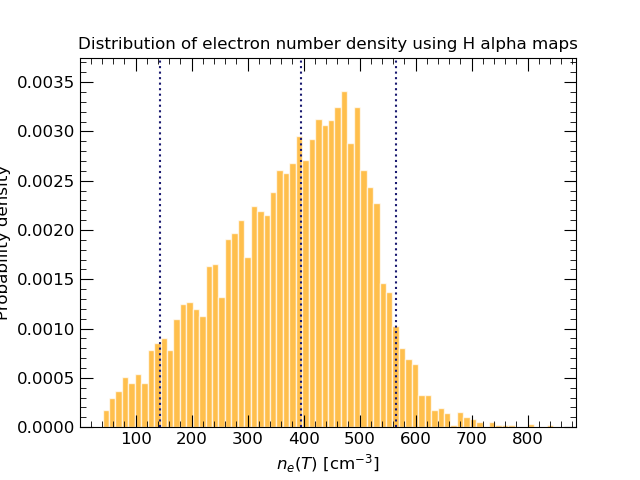

In [34]:
median = np.nanpercentile(elec_density_Ha,50)
low_lim = np.nanpercentile(elec_density_Ha,5)
high_lim = np.nanpercentile(elec_density_Ha,95)
print(median,low_lim,high_lim)
histplot = plt.hist(elec_density_Ha,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,400)
plt.title('Distribution of electron number density using H alpha maps')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

<IPython.core.display.Javascript object>


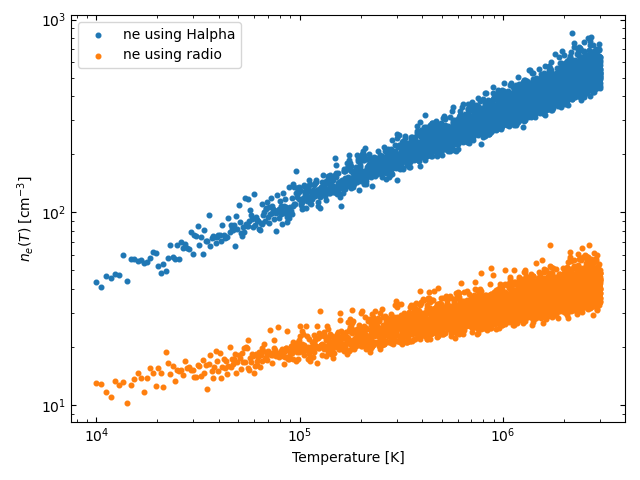

In [37]:
#To plot the variation of ne with T_axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Temperature [K]', fontsize=10)
ax.set_ylabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=10)
plt.tight_layout()
plt.scatter(T_axis,elec_density_Ha,s=11,label='ne using Halpha')
plt.scatter(T_axis,elec_density,s=11,label='ne using radio')
plt.legend()

## Shock velocity measurement:

Shock Velocity measurement: 
Velocity of the bow shock is given by the velocity of the leading end of the shock, which is dictated by the velocity of the end of the shocking jet.

$$ \dot{L} = \sqrt{\frac{16 k_b}{3 m_p}T}$$

where $m_p$ is the mass of the proton. 
For a strong shock in a mono-atomic gas, the expansion velocity is set by the temperature of the shocked gas. If the shock is radiative the initial post-shock temperature can be higher than that of the thermalized, bremsstrahlung-emitting gas. A stringent constraint comes from X-ray observations. In analogy with the case of Cyg X-1 we set an upper limit to the gas temperature to T ~ 10$^6$ K. In order to also include the upper limit because of the fact that bremsstrahlung can only emit upto T ~ 10$^8$ K.

In [ ]:
v_range = ( (16*T_axis*kb)/(3*mh) )**(1/2)/1e5
v_range_cm = ( (16*T_axis*kb)/(3*mh) )**(1/2)

In [ ]:
print(v_range[0],v_range[-1])

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(v_range, T_axis, 'r-', lw=3)

ax.set_ylim(1e4, 1.1e6)
#ax.set_ylim(3., 5e2)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Velocity [km s$ˆ{-1}$]')
ax.set_ylabel(r'Temperature [K]')

plt.show()

## Jet age measurement:

$$ t = \frac{3 L_j}{5 \dot{L_j}} $$

where $L_j$ is the seperation between the leading edge of the bowshock and the target and $\dot{L_j}$ is the velocity of the bow shock estimated from the temperature of the ISM.

In [ ]:
def age(disamin,d,incl,v):
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    t = 3/5*(discm/v) #time in seconds
    t_age_Myr = t/(365.*24.*60*60)/1.0E+6 #age of shock in Myr
    return t_age_Myr
    

In [ ]:
# Generating distribution arrays for measurements
len_min = np.random.normal(disamin,disamin_err, n_iter) #distance between bowshock and target in arcmin
i_angle = np.random.normal(incl,incl_err,n_iter)  #inclination angle
#Obtaining distribution of age for different input parameters
t_age = Parallel(n_jobs=n_cores,verbose=5)(delayed(age)(len_min[i],dist[i],i_angle[i],v_range_cm[i]) for i in range(n_iter))


In [ ]:
median = np.percentile(t_age,50)
low_lim = np.percentile(t_age,5)
high_lim = np.percentile(t_age,95)
print(median,low_lim,high_lim)
histplot = plt.hist(t_age,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Age [Myr]', fontsize=12)
plt.xlim(0,0.2)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

Assuming that the jet direction remains constant over time,  and that the jet is colliding with a medium of density $\rho_0$, the power Q$_{jet}$ being transported by the jets averaged over its lifetime, **solely dependent on the properties of the ISM** at the interaction site. Combining the equations for $L_j$ and $\dot{L_j}$ we obtain: 


$$ Q_{jet} = (\frac{5}{3})^3~\frac{\rho_0}{C1^5}L_j^2 ~\dot{L_j}^3$$

Things to note here are the differences with the literature. For eg. the C1 constant here has been used as an assumed value of 1 in Gallo et al. 2005 and as 1.5 in Kaiser et al. 2004. The constant C1 depends on the jet opening angle, and a value of 1 implies a jet opening angle of 90deg (unrealistic). Thus, we will instead go with the C1 value of 1.5 to be consistent with literature but also be more physically possible. The better ooption would have been measured values of the opening angle but that has not been conclusively done so far. 
It may be an option to use the opening angle in Tetarenko et al. 2019 (0.4 - 1.8) deg but these measurements are not solid, so they can be used as a caveat.

In [ ]:
def power(theta,nee,disamin,vcm):
    theta_rad = theta*math.pi/180           # Jet opening angle, in radiants
    C2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = math.sqrt((1/4*(C2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    C3 = math.pi/(4*Rax**2)
    C1 = ((C2)/(C3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(C2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    #nt=ne/x #where x is the ionisation fraction and is 1, use ne and nt interchangeably in the next equation
    rho = nee*1.370*mh;                    # Density of the gas down-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                         # Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(C1**5)*discm**2*vcm**3   
    return Pjet

In [ ]:
# Generating distribution arrays for measurements
open_angle = np.random.uniform(o_a_err,o_a, n_iter) #opening angle
#Obtaining distribution of age for different input parameters
power_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(power)(open_angle[i],elec_density[i],len_min[i],v_range_cm[i]) for i in range(n_iter))


In [ ]:
median = np.percentile(power_j,50)
low_lim = np.percentile(power_j,5)
high_lim = np.percentile(power_j,95)
print(median,low_lim,high_lim)
histplot = plt.hist(power_j,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Power', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [ ]:
#The constant C1 can ba calculated making assumptions on the jet properties and on the environment, 
#which we will treat as uniform in density. 

#The constant C1 is given by the following (see Appendix C in Tetarenko et al. 2018): 

thet = 50                               # assumed value for now, maybe can change to the range of the angles in the tetarenko paper
theta_ra = thet*math.pi/180           # Jet opening angle, in radiants

C2_0 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
Rax_0 = math.sqrt((1/4*(C2/theta_ra**2))) # axial ratio of the jet-blown cavity                         
C3_0 = math.pi/(4*Rax_0**2)
C1_0 = ((C2_0)/(C3_0*theta_ra**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(C2/(4*theta_ra**2))) - 4 - beta)) )**(1/(5-beta))

print('C1 ~ ',C1_0)

In [ ]:
open_a = np.random.uniform(1,20, n_iter) #opening angle
g_c = np.random.uniform(4/3,5/3, n_iter) #opening angle
g_j = np.random.uniform(4/3,5/3, n_iter) #opening angle

In [ ]:
def C_cons(g_c,g_j,g_x,ope):
    theta_ra = ope*math.pi/180           # Jet opening angle, in radiants
    C2_0 = (((g_c-1)*(g_j-1))/(4*g_c) + 1 )**(g_c/(g_c-1)) * ((g_j+1)/(g_j-1))
    Rax_0 = math.sqrt((1/4*(C2/theta_ra**2))) # axial ratio of the jet-blown cavity                         
    C3_0 = math.pi/(4*Rax_0**2)
    C1_0 = ((C2_0)/(C3_0*theta_ra**2)*((g_x+1)*(g_c-1)*(5-beta)**3)/(18*(9*(g_c + (g_c -1)*(C2/(4*theta_ra**2))) - 4 - beta)) )**(1/(5-beta))
    return C1_0

In [ ]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))


In [ ]:
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print(median,low_lim,high_lim)
histplot = plt.hist(ce_1,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Varying all three')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [ ]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],(5.0/3),(5.0/3),open_a[i]) for i in range(n_iter))
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print(median,low_lim,high_lim)
histplot = plt.hist(ce_1,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_j')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [ ]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)((5.0/3),g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print(median,low_lim,high_lim)
histplot = plt.hist(ce_1,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_c')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [ ]:
ring_thickness_arcmin = 1.5 *u.arcmin
D = 2.2e3 *u.parsec
print(ring_thickness_arcmin)
ring_thickness_arcsec = ring_thickness_arcmin.to(u.arcsec)
arcsec_to_size = (1 * u.arcsec).to(u.radian).value * D # the conversion between arcsecond to size at the distance of Cyg X-1
ring_thickness_parsec = (ring_thickness_arcsec.value*arcsec_to_size)
ring_thickness_cm = ring_thickness_parsec.to(u.cm)


In [ ]:
T = 1e6*u.Kelvin
Sh = 2.5e-16 * u.erg * ((u.second)**-1)*((u.cm)**-2)*((u.arcsecond)**-2)
Ch = 2.85e-33* u.erg * ((u.second)**-1)*((u.cm)**-3)*((u.arcsecond)**-2)

In [ ]:
Bowshock_area = 84000 *((u.arcsecond**2)) #using area and depth
Volume = Bowshock_area*ring_thickness_arcsec
Volume_pc = Volume.value*(arcsec_to_size**3)
Volume_cm = Volume_pc.to((u.cm)**3)
print(Volume_cm)

In [ ]:
#Unit Volume using beamsize and a cylindrical element
V = np.pi*(6*u.arcsec)*(6*u.arcsec)*ring_thickness_arcsec
V_pc = V.value*(arcsec_to_size**3)
V_cm = V_pc.to((u.cm)**3)
print(V_cm)

In [ ]:
#calculating ne using average flux and ring thickness
flux_av = 0.00014

In [ ]:
L14 = F*Jy*4*math.pi*(d*1e3*pc)**2 # Monochormatic ring luminosity in erg/sec/Hz
#Vol = (DR*proj_shock*(d*1e3*4.8*1e-6*pc)**3)
kappa_nu = L14 / ring_thickness_cm
ne_squared = kappa_nu/(C_radio*((1e6)**-0.5) * gaunt(nu, 1e6, Z))
n_e = (ne_squared**0.5) # units: cm^-3
print(n_e)


In [ ]:
V = np.pi*(6*u.arcsec)*(6*u.arcsec)*ring_thickness_arcsec

In [ ]:
V_pc = V.value*(arcsec_to_size**3)
V_cm = V_pc.to((u.cm)**3)
print(V_cm)